In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline
from sklearn import decomposition
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering



---



# [ 데이터 전처리 ]

### 1) Year , 0~16 값은 2000년 추가 / 기타값은 1900년 추가


### 2) Sales , 단위 통일화 , M 삭제 , K 값은 K삭제후 0.001 곱하기

### 3) 결측치정리 , 결측치가 1개 이상 포함된 데이터행 총 321개
##### (그중 퍼블리셔 결측치 37개는 Unknown과 합쳐서 데이터 유지)
##### (나머지 결측치 데이터행은 제거)

In [ ]:
df = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv")
del df['Unnamed: 0']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [ ]:
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

In [ ]:
df.shape #인덱스 수 총 16598

(16598, 9)

In [ ]:
df.isnull().sum() #항목별 결측치 , 이중 Publisher 결측치는 Unknown 값으로 합쳐 유지

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [ ]:
df['Publisher'] = df['Publisher'].replace(np.nan,'Unknown')

In [ ]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher        0
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

#### Year 결측치 항 제거 (271개)

In [ ]:
df = df.dropna(axis=0, how='any')

In [ ]:
df.shape

(16277, 9)

In [ ]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64



---



####  Year 값중 연도표시 오류 수정

In [ ]:
def convert(x):
    if x < 20 : 
        return x + 2000
    elif x >= 20 and x < 100 : 
        return x+1900
    else :
        return x

df['Year'] = df['Year'].apply(convert)

####  Sales , 단위 통일화 (기본단위 K)
####  K 삭제 / M 삭제 후 *1000  and float

In [ ]:
def value_to_float(x):
    if 'K' in x:
        return float(x.replace('K', ''))
    elif 'M' in x:
        return float(x.replace('M', '')) * 1000
    else :
        return float(x) * 1000

In [ ]:
df['NA_Sales'] = df['NA_Sales'].apply(value_to_float)
df['EU_Sales'] = df['EU_Sales'].apply(value_to_float)
df['JP_Sales'] = df['JP_Sales'].apply(value_to_float)
df['Other_Sales'] = df['Other_Sales'].apply(value_to_float)

In [ ]:
df.head(30)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40.0,0.0,0.0,0.0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170.0,0.0,0.0,10.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20.0,0.0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40.0,0.0,0.0,0.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120.0,90.0,0.0,40.0
5,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0.0,0.0,140.0,0.0
6,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,20.0,10.0,0.0,0.0
7,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,70.0,0.0,110.0,10.0
8,Imabikisou,PS3,2007.0,Adventure,Sega,0.0,0.0,40.0,0.0
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011.0,Action,THQ,40.0,30.0,0.0,10.0


In [ ]:
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object



---



### 4) 매출데이터는 누적데이터이므로 , 연평균 매출 데이터 추가 
### 추가할 셀 누적출시연도 , 연평균매출액 (기준연도 2020년)

In [ ]:
df['How_Many_Year'] = 2020 - df['Year']

In [ ]:
df['Per_NA_Sales'] = df['NA_Sales'] / df['How_Many_Year']
df['Per_EU_Sales'] = df['EU_Sales'] / df['How_Many_Year']
df['Per_JP_Sales'] = df['JP_Sales'] / df['How_Many_Year']
df['Per_Other_Sales'] = df['Other_Sales'] / df['How_Many_Year']

In [ ]:
df.dtypes

Name                object
Platform            object
Year               float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
How_Many_Year      float64
Per_NA_Sales       float64
Per_EU_Sales       float64
Per_JP_Sales       float64
Per_Other_Sales    float64
dtype: object



---



### 5) 누적총매출 , 누적 연평균총매출 생성

In [ ]:
df['Total_Sales'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']

In [ ]:
df['Per_Total_Sales'] = df['Per_NA_Sales']+df['Per_EU_Sales']+df['Per_JP_Sales']+df['Per_Other_Sales']

In [ ]:
df.head(2)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,How_Many_Year,Per_NA_Sales,Per_EU_Sales,Per_JP_Sales,Per_Other_Sales,Total_Sales,Per_Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40.0,0.0,0.0,0.0,12.0,3.333333,0.0,0.0,0.000000,40.0,3.333333
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,11.0,15.454545,0.0,0.0,0.909091,180.0,16.363636


In [ ]:
df.isnull().sum()

Name               0
Platform           0
Year               0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
How_Many_Year      0
Per_NA_Sales       0
Per_EU_Sales       1
Per_JP_Sales       1
Per_Other_Sales    0
Total_Sales        0
Per_Total_Sales    1
dtype: int64

In [ ]:
df = df.dropna()

# [ 데이터 전처리 완료 ]
### 항목
#### Name, Platform, Year, Genre, Publisher
#### NA_Sales, EU_Sales, JP_Sales, Other_Sales, How_Many_Year
#### Per_NA_Sales, Per_EU_Sales, Per_JP_Sales, Per_Other_Sales
#### Total_Sales, Per_Total_Sales

In [ ]:
#df['Genre'].unique()



---



# [ 데이터 분석 ]


### 1) 가장 많은 게임이 출시된 플랫폼은?

In [ ]:
df_1 = df.loc[:,['Name','Year','Genre','Platform', 'Total_Sales','Per_Total_Sales']]

In [ ]:
df_1.head(3)

,Name,Year,Genre,Platform,Total_Sales,Per_Total_Sales
0,Candace Kane's Candy Factory,2008.0,Action,DS,40.0,3.333333
1,The Munchables,2009.0,Action,Wii,180.0,16.363636
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,2010.0,Adventure,PSP,20.0,2.000000


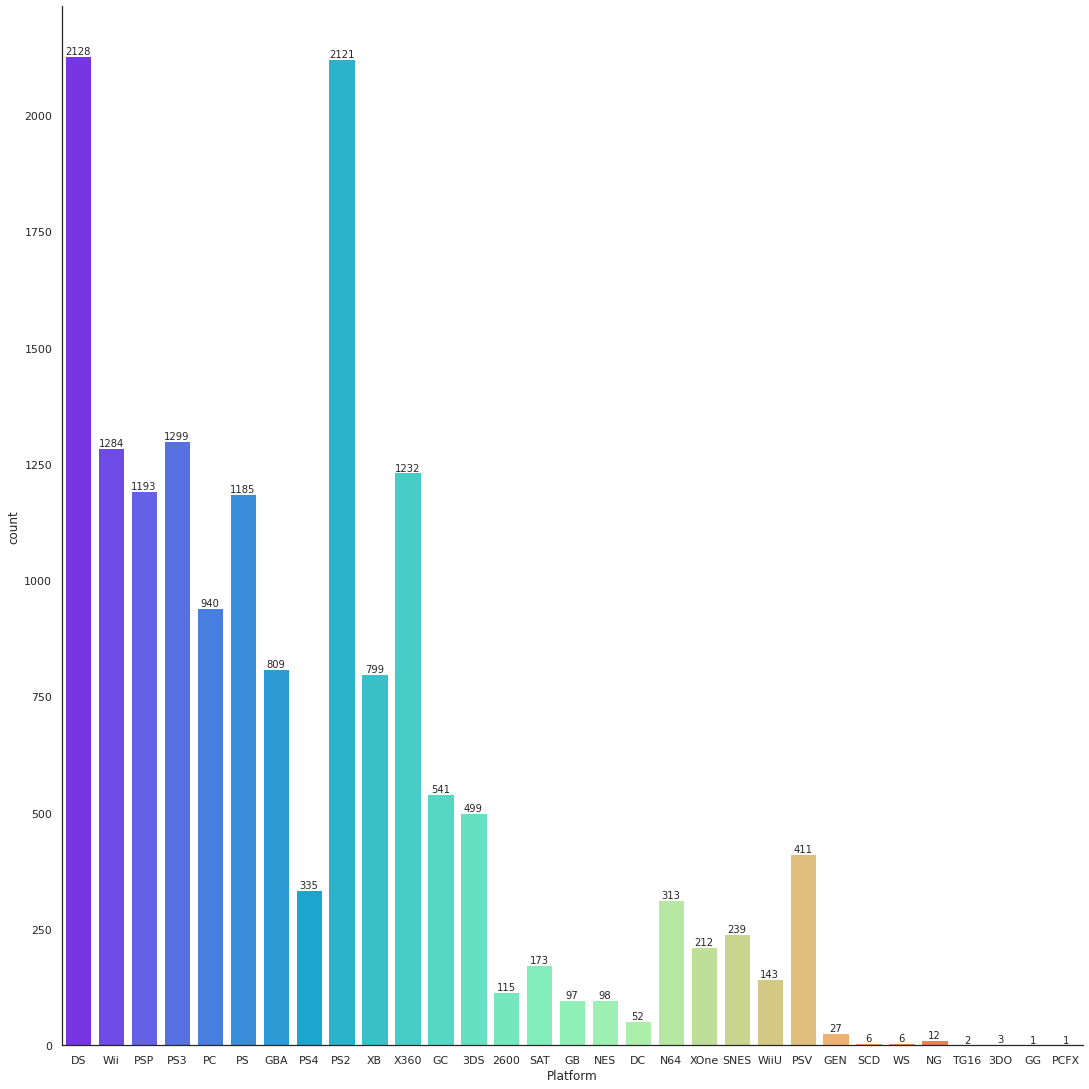

In [ ]:
plot = sns.catplot(x="Platform", kind="count", palette="rainbow", data=df_1 , height = 15)

for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, 
        h+10, 
        '{}'.format(int(h)),
        ha='center', 
        va='center',  
        size=10)

#### 닌텐도계열 : 총 5477개 (DS, Wii, GBA, 3DS, WiiU, GB, NES, N64)
#### PS계열 : 총 6646개 (PSP, PS3, PS, PS4, PS2, PSV)
#### XBOX계열 : 총 2302개 (XB, X360, XOne)

### 1) 결론
### 게임회사들은 1순위 PS계열 , 2순위 닌텐도계열 게임출시가 많다



---



### 2) 두 플랫폼에서 매출이 높은 장르는?

In [ ]:
def to_group(x):
    if 'PSP' in x:
        return x.replace('PSP', 'Sony')
    elif 'PS3' in x:
        return x.replace('PS3', 'Sony')
    elif 'PSV' in x:
        return x.replace('PSV', 'Sony')
    elif 'PS4' in x:
        return x.replace('PS4', 'Sony')
    elif 'PS2' in x:
        return x.replace('PS2', 'Sony')
    elif 'PS' in x:
        return x.replace('PS', 'Sony')
    elif 'DS' in x:
        return x.replace('DS', 'Nintendo')
    elif 'WiiU' in x:
        return x.replace('WiiU', 'Nintendo')
    elif 'GBA' in x:
        return x.replace('GBA', 'Nintendo')
    elif '3DS' in x:
        return x.replace('3DS', 'Nintendo')
    elif 'GB' in x:
        return x.replace('GB', 'Nintendo')
    elif 'NES' in x:
        return x.replace('NES', 'Nintendo')
    elif 'N64' in x:
        return x.replace('N64', 'Nintendo')
    elif 'Wii' in x:
        return x.replace('Wii', 'Nintendo')
    else :
        return x

In [ ]:
df_1['Platform_group'] = df_1['Platform'].apply(to_group)

In [ ]:
df_1 = df_1[df_1['Platform_group'].isin(['Sony','Nintendo'])]

In [ ]:
df_1.head(10)

,Name,Year,Genre,Platform,Total_Sales,Per_Total_Sales,Platform_group
0,Candace Kane's Candy Factory,2008.0,Action,DS,40.0,3.333333,Nintendo
1,The Munchables,2009.0,Action,Wii,180.0,16.363636,Nintendo
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,2010.0,Adventure,PSP,20.0,2.000000,Sony
3,Deal or No Deal: Special Edition,2010.0,Misc,DS,40.0,4.000000,Nintendo
4,Ben 10 Ultimate Alien: Cosmic Destruction,2010.0,Platform,PS3,250.0,25.000000,Sony
5,Power Pro Kun Pocket 8,2005.0,Sports,DS,140.0,9.333333,Nintendo
7,Samurai Warriors: State of War,2005.0,Action,PSP,190.0,12.666667,Sony
8,Imabikisou,2007.0,Adventure,PS3,40.0,3.076923,Sony
9,The Penguins of Madagascar: Dr. Blowhole Retur...,2011.0,Action,PS3,80.0,8.888889,Sony
10,Ford Racing,2001.0,Racing,PS,870.0,45.789474,Sony


In [ ]:
import plotly.express as px
fig = px.scatter(df_1, x="Year", y="Genre", size="Total_Sales", color="Platform_group",
           hover_name="Name", log_x=True, size_max=60)
fig.update_layout(xaxis_range=[1900,2020])
fig.show()


In [ ]:
import plotly.express as px
fig = px.scatter(df_1, x="Year", y="Genre", size="Per_Total_Sales", color="Platform_group",
           hover_name="Name", log_x=True, size_max=60)
fig.update_layout(xaxis_range=[1900,2020])
fig.show()

#### 1번 그래프 : 연도별 , 게임 장르별 , 누적 매출액
#### 2번 그래프 : 연도별 , 게임 장르별 , 연평균 매출액

##### 닌텐도 : 2005년~2010년 출시한 게임들 흥행하였지만 이후 히트작 없음
##### 스포츠 , 플랫폼 , 레이싱에 매출이 집중되어 있음
##### 소니 : 닌텐도보다 고른 분포로 게임 출시 및 누적매출 분포
##### 액션 , 슈팅 스포츠, 롤플레잉 장르에 조금더 큰 매출발생


### 2) 결론
### PS(소니) 계열로 출시할 시 액션 또는 슈팅장르로
### 닌텐도 계열로 출시할 시 스포츠, 레이싱, 플랫폼 장르로 출시해야 한다

### 3) 매출이 높은 게임들의 특징 분석

In [393]:
df_2 = df.sort_values(by='Per_Total_Sales', ascending=False)
df_2 = df_2.head(50)
df_2

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,How_Many_Year,Per_NA_Sales,Per_EU_Sales,Per_JP_Sales,Per_Other_Sales,Total_Sales,Per_Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,14.0,2963.571429,2072.857143,269.285714,604.285714,82740.0,5910.000000
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7010.0,9270.0,970.0,4140.0,7.0,1001.428571,1324.285714,138.571429,591.428571,21390.0,3055.714286
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,11.0,1431.818182,1000.909091,298.181818,269.090909,33000.0,3000.000000
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15850.0,12880.0,3790.0,3310.0,12.0,1320.833333,1073.333333,315.833333,275.833333,35830.0,2985.833333
9070,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,Activision,5770.0,5810.0,350.0,2310.0,5.0,1154.000000,1162.000000,70.000000,462.000000,14240.0,2848.000000
16531,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14590.0,7060.0,4700.0,2260.0,11.0,1326.363636,641.818182,427.272727,205.454545,28610.0,2600.909091
10913,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9630.0,5310.0,60.0,1380.0,7.0,1375.714286,758.571429,8.571429,197.142857,16380.0,2340.000000
4343,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14970.0,4940.0,240.0,1670.0,10.0,1497.000000,494.000000,24.000000,167.000000,21820.0,2182.000000
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11380.0,9230.0,6500.0,2900.0,14.0,812.857143,659.285714,464.285714,207.142857,30010.0,2143.571429
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14030.0,9200.0,2930.0,2850.0,14.0,1002.142857,657.142857,209.285714,203.571429,29010.0,2072.142857


In [394]:
df_2 = df_2.loc[:,['Name','Per_Total_Sales']]

In [401]:
df_2['Arranged_Name'] = ['Wii', 'Grand Theft Auto' ,'Wii', 'Mario' ,'Call of Duty', 'Mario' ,'Grand Theft Auto' ,'Kinect Adventures!', 'Mario', 'Wii', 'Wii', 'Grand Theft Auto', 'Pokemon' ,'Call of Duty', 'Wii', 'Call of Duty' ,'FIFA', 'Nintendogs' ,'Call of Duty', 'Mario', 'Star Wars Battlefront (2015)', 'Call of Duty' ,'Call of Duty', 'Call of Duty' ,'Call of Duty' ,'Fallout 4' ,'Call of Duty', 'Mario', 'Brain Age', 'Minecraft', 'Pokemon', 'Pokemon', 'Grand Theft Auto', 'Call of Duty', 'Call of Duty' ,'Mario' ,'Call of Duty', 'Mario' ,'Halo 4' ,'Mario' ,'FIFA' ,'Mario' ,'Mario', 'Just Dance 3', 'Animal Crossing','FIFA', 'Pokemon', 'Mario', 'Pokemon', 'Gran Turismo 5']

In [402]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
fig = px.pie(df_2, values='Per_Total_Sales', names='Arranged_Name')
fig.show()


In [403]:
df_2 = df.sort_values(by='Total_Sales', ascending=False)
df_2 = df_2.head(50)
df_2

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,How_Many_Year,Per_NA_Sales,Per_EU_Sales,Per_JP_Sales,Per_Other_Sales,Total_Sales,Per_Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,14.0,2963.571429,2072.857143,269.285714,604.285714,82740.0,5910.000000
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29080.0,3580.0,6810.0,770.0,35.0,830.857143,102.285714,194.571429,22.000000,40240.0,1149.714286
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15850.0,12880.0,3790.0,3310.0,12.0,1320.833333,1073.333333,315.833333,275.833333,35830.0,2985.833333
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,11.0,1431.818182,1000.909091,298.181818,269.090909,33000.0,3000.000000
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11270.0,8890.0,10220.0,1000.0,24.0,469.583333,370.416667,425.833333,41.666667,31380.0,1307.500000
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23200.0,2260.0,4220.0,580.0,31.0,748.387097,72.903226,136.129032,18.709677,30260.0,976.129032
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11380.0,9230.0,6500.0,2900.0,14.0,812.857143,659.285714,464.285714,207.142857,30010.0,2143.571429
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14030.0,9200.0,2930.0,2850.0,14.0,1002.142857,657.142857,209.285714,203.571429,29010.0,2072.142857
16531,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14590.0,7060.0,4700.0,2260.0,11.0,1326.363636,641.818182,427.272727,205.454545,28610.0,2600.909091
10488,Duck Hunt,NES,1984.0,Shooter,Nintendo,26930.0,630.0,280.0,470.0,36.0,748.055556,17.500000,7.777778,13.055556,28310.0,786.388889


In [404]:
df_2 = df_2.loc[:,['Name','Total_Sales']]

In [405]:
df_2['Arranged_Name'] = ['Wii', 'Mario', 'Mario', 'Wii', 'Pokemon' ,'Tetris', 'Mario' ,'Wii', 'Mario', 'Duck Hunt', 'Nintendogs' ,'Mario', 'Pokemon' ,'Wii' ,'Wii' ,'Kinect Adventures' ,'Grand Theft Auto', 'Grand Theft Auto' ,'Mario' ,'Brain Age', 'Pokemon', 'Mario', 'Mario' ,'Grand Theft Auto' ,'Grand Theft Auto' ,'Pokemon', 'Pokemon' ,'Brain Age', 'Grand Turismo' ,'Call of Duty' ,'Call of Duty', 'Pokemon', 'Call of Duty', 'Call of Duty', 'Call of Duty', 'Call of Duty' ,'Call of Duty' ,'Grand Theft Auto', 'Mario' ,'Call of Duty', 'Animal Crossing', 'Mario', 'Halo' ,'Grand Theft Auto', 'Pokemon', 'Mario', 'Grand Turismo' ,'Mario', 'Pokemon', 'Mario']

In [406]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
fig = px.pie(df_2, values='Total_Sales', names='Arranged_Name')
fig.show()

#### 상위 50개 게임중 시리즈 80% 이상이 연속성을 갖는 시리즈게임

### 3) 결론
### 아예 새로운 게임개발보다는 기존 게임 IP 를 활용한 게임개발,
### 또는 조인트런칭도 좋은 방향일수있음




---



### 4) PCA 분석

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 

In [ ]:
#df_3 = df.loc[:,['Year','Genre','Total_Sales','Per_Total_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
df_3 = df.loc[:,['Genre','Total_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

In [ ]:
#pd.get_dummies(df_3, columns = ['Genre'])

In [ ]:
#del df_3['Genre']
#del df_3['Publisher']

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Total_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
# Separating out the features
x = df_3.loc[:, features].values
# Separating out the target
y = df_3.loc[:,['Genre']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df_3[['Genre']]], axis = 1)

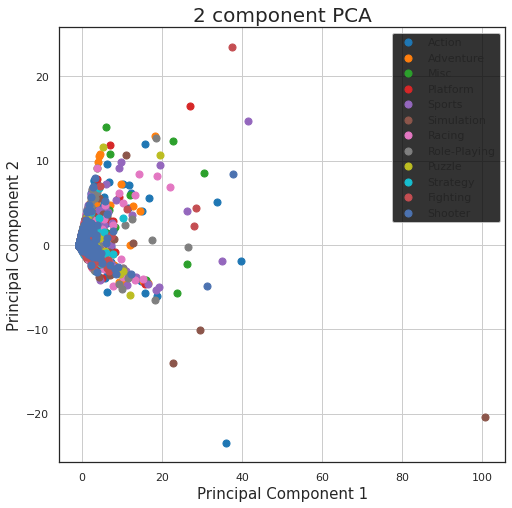

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Action', 'Adventure', 'Misc', 'Platform', 'Sports', 'Simulation',
       'Racing', 'Role-Playing', 'Puzzle', 'Strategy', 'Fighting',
       'Shooter']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Genre'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### PCA 분석결과 유의미한 값을 찾을수 없었음
#### 실질적으로 게임이름 , 출시년 , 장르 , 플랫폼 , 매출액 중 PCA 테스트로 가능한 변수값 제한적

### 4) 결론
PCA분석을 통해서는 유의미한 결과 얻기 어려움



---



### 5) 지역에 따라 선호하는 게임 장르는?

#### 변수 : 게임장르 , 지역별 누적매출
#### 방법 : 박스 플롯으로 시각화

In [ ]:
df_4 = df.loc[:,['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

In [ ]:
df_4.head()

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Action,40.0,0.0,0.0,0.0
1,Action,170.0,0.0,0.0,10.0
2,Adventure,0.0,0.0,20.0,0.0
3,Misc,40.0,0.0,0.0,0.0
4,Platform,120.0,90.0,0.0,40.0


In [ ]:
grouped = df_4.groupby('Genre')
df_grouped = grouped.sum().reset_index()
df_grouped

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Action,858780.0,513640.0,156610.0,183990.0
1,Adventure,101920.0,63710.0,51890.0,16700.0
2,Fighting,220350.0,99900.0,87140.0,36150.0
3,Misc,400290.0,210200.0,104180.0,72740.0
4,Platform,445380.0,200650.0,130530.0,51450.0
5,Puzzle,121580.0,50480.0,56240.0,12440.0
6,Racing,354700.0,235030.0,56320.0,76510.0
7,Role-Playing,318760.0,183100.0,342930.0,56730.0
8,Shooter,574480.0,310230.0,38180.0,101860.0
9,Simulation,181160.0,113170.0,63540.0,31300.0


In [ ]:
tidy = df_grouped.melt(id_vars = 'Genre', value_vars = ['NA_Sales', 'EU_Sales','JP_Sales','Other_Sales'])
tidy.head(50)

,Genre,variable,value
0,Action,NA_Sales,858780.0
1,Adventure,NA_Sales,101920.0
2,Fighting,NA_Sales,220350.0
3,Misc,NA_Sales,400290.0
4,Platform,NA_Sales,445380.0
5,Puzzle,NA_Sales,121580.0
6,Racing,NA_Sales,354700.0
7,Role-Playing,NA_Sales,318760.0
8,Shooter,NA_Sales,574480.0
9,Simulation,NA_Sales,181160.0


In [ ]:
variable_by_Genre_1 = tidy[tidy['Genre'] == 'Action'].groupby('variable').value.sum()
variable_by_Genre_2 = tidy[tidy['Genre'] == 'Adventure'].groupby('variable').value.sum()
variable_by_Genre_3 = tidy[tidy['Genre'] == 'Fighting'].groupby('variable').value.sum()
variable_by_Genre_4 = tidy[tidy['Genre'] == 'Misc'].groupby('variable').value.sum()
variable_by_Genre_5 = tidy[tidy['Genre'] == 'Platform'].groupby('variable').value.sum()
variable_by_Genre_6 = tidy[tidy['Genre'] == 'Puzzle'].groupby('variable').value.sum()
variable_by_Genre_7 = tidy[tidy['Genre'] == 'Racing'].groupby('variable').value.sum()
variable_by_Genre_8 = tidy[tidy['Genre'] == 'Role-Playing'].groupby('variable').value.sum()
variable_by_Genre_9 = tidy[tidy['Genre'] == 'Shooter'].groupby('variable').value.sum()
variable_by_Genre_10 = tidy[tidy['Genre'] == 'Simulation'].groupby('variable').value.sum()
variable_by_Genre_11 = tidy[tidy['Genre'] == 'Sports'].groupby('variable').value.sum()
variable_by_Genre_12 = tidy[tidy['Genre'] == 'Strategy'].groupby('variable').value.sum()

In [ ]:
variable_by_Genre_1

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

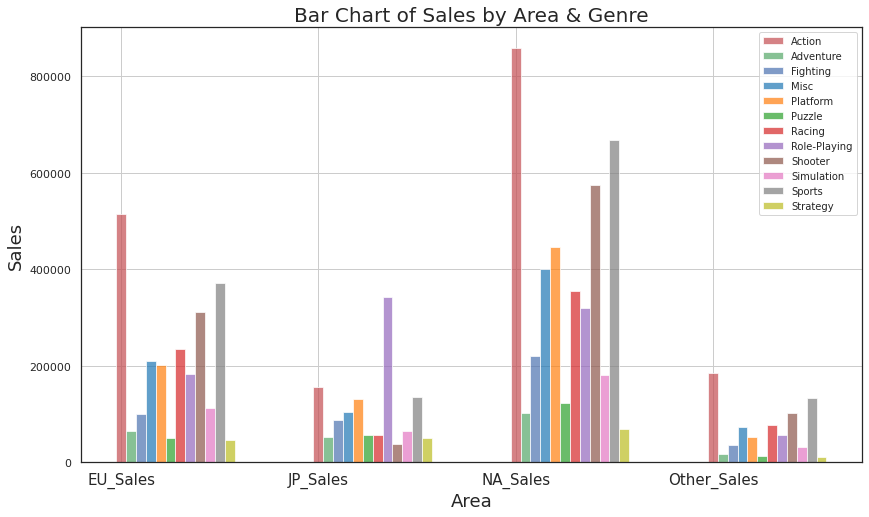

In [ ]:
label = ['EU_Sales', 'JP_Sales', 'NA_Sales' , 'Other_Sales']
N = len(tidy['variable'].unique())
index = np.arange(N)

bar_width = 0.05
alpha = 0.7

p1 = plt.bar(index, variable_by_Genre_1, bar_width, color='r', alpha=alpha, label='Action')
p2 = plt.bar(index + bar_width * 1, variable_by_Genre_2, bar_width, color='g', alpha=alpha,label='Adventure')
p3 = plt.bar(index + bar_width * 2, variable_by_Genre_3, bar_width, color='b', alpha=alpha,label='Fighting')
p4 = plt.bar(index + bar_width * 3, variable_by_Genre_4, bar_width, color='#1f77b4', alpha=alpha,label='Misc')
p5 = plt.bar(index + bar_width * 4, variable_by_Genre_5, bar_width, color='#ff7f0e', alpha=alpha,label='Platform')
p6 = plt.bar(index + bar_width * 5, variable_by_Genre_6, bar_width, color='#2ca02c', alpha=alpha,label='Puzzle')
p7 = plt.bar(index + bar_width * 6, variable_by_Genre_7, bar_width, color='#d62728', alpha=alpha,label='Racing')
p8 = plt.bar(index + bar_width * 7, variable_by_Genre_8, bar_width, color='#9467bd', alpha=alpha,label='Role-Playing')
p9 = plt.bar(index + bar_width * 8, variable_by_Genre_9, bar_width, color='#8c564b', alpha=alpha,label='Shooter')
p10 = plt.bar(index + bar_width * 9, variable_by_Genre_10, bar_width, color='#e377c2', alpha=alpha,label='Simulation')
p11 = plt.bar(index + bar_width * 10, variable_by_Genre_11, bar_width, color='#7f7f7f', alpha=alpha,label='Sports')
p12 = plt.bar(index + bar_width * 11, variable_by_Genre_12, bar_width, color='#bcbd22', alpha=alpha,label='Strategy')

plt.title('Bar Chart of Sales by Area & Genre', fontsize=20)
plt.ylabel('Sales', fontsize=18)
plt.xlabel('Area', fontsize=18)
plt.xticks(index, label, fontsize=15)
plt.legend((p1[0], p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0],p11[0],p12[0]), ('Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports','Strategy'), fontsize=10, facecolor='white')
plt.show()

#### NA 지역 : 액션 , 스포츠 , 슈팅 순
#### EU 지역 : 액션 , 스포츠 , 슈팅 순
#### JP 지역 : 롤플레잉, 액션 , 스포츠 순
#### 기타지역 : 액션 , 스포츠 , 슈팅 순

### 5) 결론
### 시장이 가장 큰 북미와 유럽을 타겟으로 액션 장르 



---



### 6) 연도별 게임 트렌드는?
#### 연도별 , 장르
#### scatterplot 으로 시각화

In [ ]:
df_5 = df.loc[:,['Year', 'Genre']]
df_5

,Year,Genre
0,2008.0,Action
1,2009.0,Action
2,2010.0,Adventure
3,2010.0,Misc
4,2010.0,Platform
...,...,...
16593,2006.0,Platform
16594,2005.0,Action
16595,2015.0,Sports
16596,2013.0,Action


In [385]:
grouped_df_5 = df_5.groupby(["Year", "Genre"]).size().reset_index()
grouped_df_5
type(grouped_df_5)

pandas.core.frame.DataFrame

In [389]:
grouped_df_5.columns = ["Year", "Genre", "Value"]
grouped_df_5

,Year,Genre,Value
0,1980.0,Action,1
1,1980.0,Fighting,1
2,1980.0,Misc,4
3,1980.0,Shooter,2
4,1981.0,Action,25
...,...,...,...
382,2016.0,Simulation,9
383,2016.0,Sports,38
384,2016.0,Strategy,10
385,2017.0,Action,1


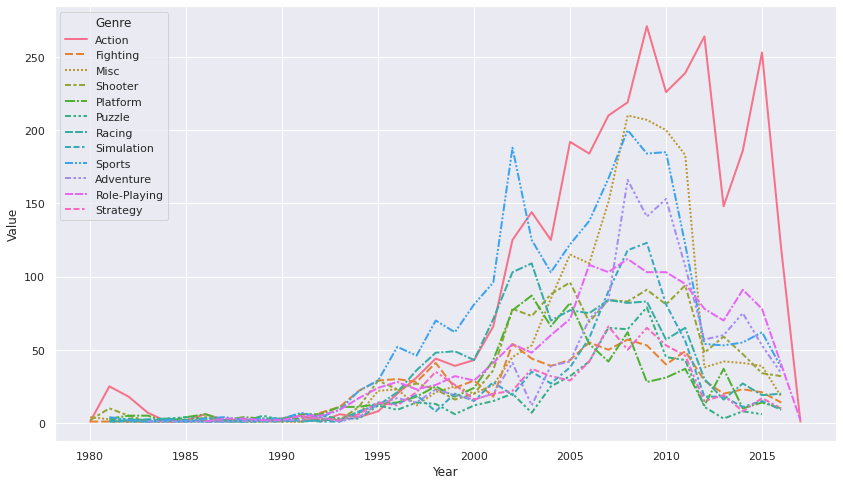

In [392]:
sns.set_style('darkgrid', {'legend.frameon':True})
sns.lineplot(data=grouped_df_5, x="Year", y="Value", hue="Genre", style="Genre")

#### 액션장르가 연도 통틀어 늘 높은 수치
#### 2005년부터 2010년 사이 가장 많은 게임이 출시됨

### 6) 결론
#### 2000년 ~ 2005년 스포츠와 액션 위주
#### 2005년 ~ 2010년 액션 선두 , 어드벤처 및 Misc(기타) 장르 급증
#### 2010년 ~ 2015년 액션 계속 선두, 롤플레잉 장르 성장

# [데이터 분석 완료]

### 게임 플랫폼 : Playstation
### 게임 장르 : 액션
### 우선타겟지역 : NA 및 EU
### 전략 : 1) 시리즈물 -> IP 활용 게임 런칭 , 2) 게임제작사와 조인트벤처
